<a href="https://colab.research.google.com/github/Ciss48/Optimize_level_time/blob/main/Optimize_time_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_id = 'crazy-coffee-jam'

from google.colab import auth
auth.authenticate_user()
# Construct a BigQuery client object.
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

# Prepare df

In [ ]:
version = '1.0.18'
start_date = '2025-06-01'
level_end = 100
end_date = ''

In [ ]:
query = f"""
WITH start_users AS (
  SELECT
    level,
    COUNT(DISTINCT user_pseudo_id) as start_user
  FROM `crazy-coffee-jam.flatten_table.start_level`
  WHERE event_date >= '{start_date}'
    AND version = '{version}'
    AND level <= {level_end}
  GROUP BY level
),
win_stats AS (
  SELECT
    level,
    COUNT(DISTINCT user_pseudo_id) as win_user,
    SUM(COALESCE(revive,0)) as num_revive,
    SUM(COALESCE(booster_use,0)) as num_booster,
    AVG(count_sec) as avg_time_play_win,
    STDDEV(count_sec) as std_time_play_win,
    MAX(count_sec) as max_time_play_win,
    MIN(count_sec) as min_time_play_win,

    COUNT(DISTINCT CASE WHEN revive = 0 THEN user_pseudo_id END) as num_user_not_revive,
    AVG(CASE WHEN revive = 0 THEN count_sec END) as avg_time_win_not_revive,
    STDDEV(CASE WHEN revive = 0 THEN count_sec END) AS std_time_win_not_revive,
    MAX(CASE WHEN revive = 0 THEN count_sec END) AS max_time_win_not_revive,
    MIN(CASE WHEN revive = 0 THEN count_sec END) AS min_time_win_not_revive,

    COUNT(DISTINCT CASE WHEN booster_use = 0 THEN user_pseudo_id END) as num_user_not_booster,
    AVG(CASE WHEN booster_use = 0 THEN count_sec END) as avg_time_win_not_booster,
    STDDEV(CASE WHEN booster_use = 0 THEN count_sec END) AS std_time_win_not_booster,
    MAX(CASE WHEN booster_use = 0 THEN count_sec END) AS max_time_win_not_booster,
    MIN(CASE WHEN booster_use = 0 THEN count_sec END) AS min_time_win_not_booster,

    COUNT(DISTINCT CASE WHEN booster_use = 0 and revive = 0 THEN user_pseudo_id END) as num_user_not_resource,
    AVG(CASE WHEN booster_use = 0 and revive = 0 THEN count_sec END) as avg_time_win_not_resource,
    STDDEV(CASE WHEN booster_use = 0 and revive = 0 THEN count_sec END) AS std_time_win_not_resource,
    MAX(CASE WHEN booster_use = 0 and revive = 0 THEN count_sec END) AS max_time_win_not_resource,
    MIN(CASE WHEN booster_use = 0 and revive = 0 THEN count_sec END) AS min_time_win_not_resource,


    COUNT(DISTINCT CASE WHEN revive > 0 and booster_use = 0 THEN user_pseudo_id END) as num_user_revive,
    AVG(CASE WHEN revive > 0 and booster_use = 0 THEN count_sec END) as avg_time_win_revive,
    STDDEV(CASE WHEN revive > 0 and booster_use = 0 THEN count_sec END) AS std_time_win_revive,
    MAX(CASE WHEN revive > 0 and booster_use = 0 THEN count_sec END) AS max_time_win_revive,
    MIN(CASE WHEN revive > 0 and booster_use = 0 THEN count_sec END) AS min_time_win_revive,

    COUNT(DISTINCT  CASE WHEN booster_use > 0 and revive = 0 THEN user_pseudo_id END) as num_user_booster,
    AVG(CASE WHEN booster_use > 0 and revive = 0 THEN count_sec END) as avg_time_win_booster,
    STDDEV(CASE WHEN booster_use > 0 and revive = 0 THEN count_sec END) AS std_time_win_booster,
    MAX(CASE WHEN booster_use > 0 and revive = 0 THEN count_sec END) AS max_time_win_booster,
    MIN(CASE WHEN booster_use > 0 and revive = 0 THEN count_sec END) AS min_time_win_booster,

    COUNT(DISTINCT CASE WHEN booster_use > 0 and revive > 0 THEN user_pseudo_id END) as num_user_booster_revive,
    AVG(CASE WHEN booster_use > 0 and revive > 0 THEN count_sec END) as avg_time_win_booster_revive,
    STDDEV(CASE WHEN booster_use > 0 and revive > 0 THEN count_sec END) AS std_time_win_booster_revive,
    MAX(CASE WHEN booster_use > 0 and revive > 0 THEN count_sec END) AS max_time_win_booster_revive,
    MIN(CASE WHEN booster_use > 0 and revive > 0 THEN count_sec END) AS min_time_win_booster_revive,


    COUNT(DISTINCT CASE WHEN win_at_attempt = 1 THEN user_pseudo_id END) as num_win_user_att1,
    AVG(CASE WHEN win_at_attempt = 1 THEN count_sec END) AS avg_time_play_att1,
    STDDEV(CASE WHEN win_at_attempt = 1 THEN count_sec END) AS std_time_play_att1,
    MAX(CASE WHEN win_at_attempt = 1 THEN count_sec END) AS max_time_play_att1,
    MIN(CASE WHEN win_at_attempt = 1 THEN count_sec END) AS min_time_play_att1,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 2 THEN user_pseudo_id END) as num_win_user_att2,
    AVG(CASE WHEN win_at_attempt = 2 THEN count_sec END) AS avg_time_play_att2,
    STDDEV(CASE WHEN win_at_attempt = 2 THEN count_sec END) AS std_time_play_att2,
    MAX(CASE WHEN win_at_attempt = 2 THEN count_sec END) AS max_time_play_att2,
    MIN(CASE WHEN win_at_attempt = 2 THEN count_sec END) AS min_time_play_att2,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 1 and revive > 0 and booster_use = 0 THEN user_pseudo_id END) as num_win_user_att1_revive,
    AVG(CASE WHEN win_at_attempt = 1 and revive > 0 and booster_use = 0 THEN count_sec END) AS avg_time_play_att1_revive,
    STDDEV(CASE WHEN win_at_attempt = 1 and revive > 0 and booster_use = 0 THEN count_sec END) AS std_time_play_att1_revive,
    MAX(CASE WHEN win_at_attempt = 1 and revive > 0 and booster_use = 0 THEN count_sec END) AS max_time_play_att1_revive,
    MIN(CASE WHEN win_at_attempt = 1 and revive > 0 and booster_use = 0 THEN count_sec END) AS min_time_play_att1_revive,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 2 and revive > 0 and booster_use = 0 THEN user_pseudo_id END) as num_win_user_att2_revive,
    AVG(CASE WHEN win_at_attempt = 2 and revive > 0 and booster_use = 0 THEN count_sec END) AS avg_time_play_att2_revive,
    STDDEV(CASE WHEN win_at_attempt = 2 and revive > 0 and booster_use = 0 THEN count_sec END) AS std_time_play_att2_revive,
    MAX(CASE WHEN win_at_attempt = 2 and revive > 0 and booster_use = 0 THEN count_sec END) AS max_time_play_att2_revive,
    MIN(CASE WHEN win_at_attempt = 2 and revive > 0 and booster_use = 0 THEN count_sec END) AS min_time_play_att2_revive,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 1 and revive = 0 and booster_use > 0 THEN user_pseudo_id END) as num_win_user_att1_booster,
    AVG(CASE WHEN win_at_attempt = 1 and revive = 0 and booster_use > 0 THEN count_sec END) AS avg_time_play_att1_booster,
    STDDEV(CASE WHEN win_at_attempt = 1 and revive = 0 and booster_use > 0 THEN count_sec END) AS std_time_play_att1_booster,
    MAX(CASE WHEN win_at_attempt = 1 and revive = 0 and booster_use > 0 THEN count_sec END) AS max_time_play_att1_booster,
    MIN(CASE WHEN win_at_attempt = 1 and revive = 0 and booster_use > 0 THEN count_sec END) AS min_time_play_att1_booster,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 2 and revive = 0 and booster_use > 0 THEN user_pseudo_id END) as num_win_user_att2_booster,
    AVG(CASE WHEN win_at_attempt = 2 and revive = 0 and booster_use > 0 THEN count_sec END) AS avg_time_play_att2_booster,
    STDDEV(CASE WHEN win_at_attempt = 2 and revive = 0 and booster_use > 0 THEN count_sec END) AS std_time_play_att2_booster,
    MAX(CASE WHEN win_at_attempt = 2 and revive = 0 and booster_use > 0 THEN count_sec END) AS max_time_play_att2_booster,
    MIN(CASE WHEN win_at_attempt = 2 and revive = 0 and booster_use > 0 THEN count_sec END) AS min_time_play_att2_booster,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 1 and revive > 0 and booster_use > 0 THEN user_pseudo_id END) as num_win_user_att1_revive_booster,
    AVG(CASE WHEN win_at_attempt = 1 and revive > 0 and booster_use > 0 THEN count_sec END) AS avg_time_play_att1_revive_booster,
    STDDEV(CASE WHEN win_at_attempt = 1 and revive > 0 and booster_use > 0 THEN count_sec END) AS std_time_play_att1_revive_booster,
    MAX(CASE WHEN win_at_attempt = 1 and revive > 0 and booster_use > 0 THEN count_sec END) AS max_time_play_att1_revive_booster,
    MIN(CASE WHEN win_at_attempt = 1 and revive > 0 and booster_use > 0 THEN count_sec END) AS min_time_play_att1_revive_booster,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 2 and revive > 0 and booster_use > 0 THEN user_pseudo_id END) as num_win_user_att2_revive_booster,
    AVG(CASE WHEN win_at_attempt = 2 and revive > 0 and booster_use > 0 THEN count_sec END) AS avg_time_play_att2_revive_booster,
    STDDEV(CASE WHEN win_at_attempt = 2 and revive > 0 and booster_use > 0 THEN count_sec END) AS std_time_play_att2_revive_booster,
    MAX(CASE WHEN win_at_attempt = 2 and revive > 0 and booster_use > 0 THEN count_sec END) AS max_time_play_att2_revive_booster,
    MIN(CASE WHEN win_at_attempt = 2 and revive > 0 and booster_use > 0 THEN count_sec END) AS min_time_play_att2_revive_booster

  FROM `crazy-coffee-jam.dashboard_table.win_level_time_attemp`
  WHERE event_date >= '{start_date}'
    AND version = '{version}'
    AND level <= {level_end}
  GROUP BY level
)

SELECT
  s.level,
  s.start_user,
  w.win_user,
  COALESCE(w.num_booster,0) as num_booster,
  COALESCE(w.num_revive,0) as num_revive,
  COALESCE(w.avg_time_play_win,0) as avg_time_play_win,
  COALESCE(w.std_time_play_win,0) as std_time_play_win,
  COALESCE(w.max_time_play_win,0) as max_time_play_win,
  COALESCE(w.min_time_play_win,0) as min_time_play_win,

  COALESCE(w.num_user_not_revive,0) as num_user_not_revive,
  COALESCE(w.avg_time_win_not_revive,0) as avg_time_win_not_revive,
  COALESCE(w.std_time_win_not_revive,0) as std_time_win_not_revive,
  COALESCE(w.max_time_win_not_revive,0) as max_time_win_not_revive,
  COALESCE(w.min_time_win_not_revive,0) as min_time_win_not_revive,

  COALESCE(w.num_user_not_booster,0) as num_user_not_booster,
  COALESCE(w.avg_time_win_not_booster,0) as avg_time_win_not_booster,
  COALESCE(w.std_time_win_not_booster,0) as std_time_win_not_booster,
  COALESCE(w.max_time_win_not_booster,0) as max_time_win_not_booster,
  COALESCE(w.min_time_win_not_booster,0) as min_time_win_not_booster,

  COALESCE(w.num_user_not_resource,0) as num_user_not_resource,
  COALESCE(w.avg_time_win_not_resource,0) as avg_time_win_not_resource,
  COALESCE(w.std_time_win_not_resource,0) as std_time_win_not_resource,
  COALESCE(w.max_time_win_not_resource,0) as max_time_win_not_resource,
  COALESCE(w.min_time_win_not_resource,0) as min_time_win_not_resource,

  COALESCE(w.num_user_revive,0) as num_user_revive,
  COALESCE(w.avg_time_win_revive,0) as avg_time_win_revive,
  COALESCE(w.std_time_win_revive,0) as std_time_win_revive,
  COALESCE(w.max_time_win_revive,0) as max_time_win_revive,
  COALESCE(w.min_time_win_revive,0) as min_time_win_revive,

  COALESCE(w.num_user_booster,0) as num_user_booster,
  COALESCE(w.avg_time_win_booster,0) as avg_time_win_booster,
  COALESCE(w.std_time_win_booster,0) as std_time_win_booster,
  COALESCE(w.max_time_win_booster,0) as max_time_win_booster,
  COALESCE(w.min_time_win_booster,0) as min_time_win_booster,

  COALESCE(w.num_user_booster_revive,0) as num_user_booster_revive,
  COALESCE(w.avg_time_win_booster_revive,0) as avg_time_win_booster_revive,
  COALESCE(w.std_time_win_booster_revive,0) as std_time_win_booster_revive,
  COALESCE(w.max_time_win_booster_revive,0) as max_time_win_booster_revive,
  COALESCE(w.min_time_win_booster_revive,0) as min_time_win_booster_revive,

  COALESCE(w.num_win_user_att1,0) as num_win_user_att1,
  COALESCE(w.avg_time_play_att1,0) as avg_time_play_att1,
  COALESCE(w.std_time_play_att1,0) as std_time_play_att1,
  COALESCE(w.max_time_play_att1,0) as max_time_play_att1,
  COALESCE(w.min_time_play_att1,0) as min_time_play_att1,

  COALESCE(w.num_win_user_att2,0) as num_win_user_att2,
  COALESCE(w.avg_time_play_att2,0) as avg_time_play_att2,
  COALESCE(w.std_time_play_att2,0) as std_time_play_att2,
  COALESCE(w.max_time_play_att2,0) as max_time_play_att2,
  COALESCE(w.min_time_play_att2,0) as min_time_play_att2,

  COALESCE(w.num_win_user_att1_revive,0) as num_win_user_att1_revive,
  COALESCE(w.avg_time_play_att1_revive,0) as avg_time_play_att1_revive,
  COALESCE(w.std_time_play_att1_revive,0) as std_time_play_att1_revive,
  COALESCE(w.max_time_play_att1_revive,0) as max_time_play_att1_revive,
  COALESCE(w.min_time_play_att1_revive,0) as min_time_play_att1_revive,

  COALESCE(w.num_win_user_att2_revive,0) as num_win_user_att2_revive,
  COALESCE(w.avg_time_play_att2_revive,0) as avg_time_play_att2_revive,
  COALESCE(w.std_time_play_att2_revive,0) as std_time_play_att2_revive,
  COALESCE(w.max_time_play_att2_revive,0) as max_time_play_att2_revive,
  COALESCE(w.min_time_play_att2_revive,0) as min_time_play_att2_revive,

  COALESCE(w.num_win_user_att1_booster,0) as num_win_user_att1_booster,
  COALESCE(w.avg_time_play_att1_booster,0) as avg_time_play_att1_booster,
  COALESCE(w.std_time_play_att1_booster,0) as std_time_play_att1_booster,
  COALESCE(w.max_time_play_att1_booster,0) as max_time_play_att1_booster,
  COALESCE(w.min_time_play_att1_booster,0) as min_time_play_att1_booster,

  COALESCE(w.num_win_user_att2_booster,0) as num_win_user_att2_booster,
  COALESCE(w.avg_time_play_att2_booster,0) as avg_time_play_att2_booster,
  COALESCE(w.std_time_play_att2_booster,0) as std_time_play_att2_booster,
  COALESCE(w.max_time_play_att2_booster,0) as max_time_play_att2_booster,
  COALESCE(w.min_time_play_att2_booster,0) as min_time_play_att2_booster,

  COALESCE(w.num_win_user_att1_revive_booster,0) as num_win_user_att1_revive_booster,
  COALESCE(w.avg_time_play_att1_revive_booster,0) as avg_time_play_att1_revive_booster,
  COALESCE(w.std_time_play_att1_revive_booster,0) as std_time_play_att1_revive_booster,
  COALESCE(w.max_time_play_att1_revive_booster,0) as max_time_play_att1_revive_booster,
  COALESCE(w.min_time_play_att1_revive_booster,0) as min_time_play_att1_revive_booster,

  COALESCE(w.num_win_user_att2_revive_booster,0) as num_win_user_att2_revive_booster,
  COALESCE(w.avg_time_play_att2_revive_booster,0) as avg_time_play_att2_revive_booster,
  COALESCE(w.std_time_play_att2_revive_booster,0) as std_time_play_att2_revive_booster,
  COALESCE(w.max_time_play_att2_revive_booster,0) as max_time_play_att2_revive_booster,
  COALESCE(w.min_time_play_att2_revive_booster,0) as min_time_play_att2_revive_booster
FROM start_users s
LEFT JOIN win_stats w ON s.level = w.level
ORDER BY s.level;

"""

df = client.query(query).to_dataframe()

In [ ]:
import pandas as pd

# Giả sử bạn đã có DataFrame df với số dòng tương ứng (ví dụ: df có 100 level)
time_values = [
    3000, 300, 300, 300, 300, 240, 180, 180, 180, 180, 180, 180, 180, 180, 210,
    150, 300, 180, 150, 180, 100, 90, 120, 180, 150, 120, 90, 140, 150, 240,
    240, 210, 180, 180, 180, 120, 150, 150, 170, 130, 120, 180, 150, 120, 100,
    120, 100, 140, 120, 240, 180, 150, 140, 150, 160, 120, 150, 110, 150, 120,
    120, 180, 90, 140, 130, 180, 150, 90, 100, 180, 100, 60, 150, 120, 130, 120,
    140, 120, 100, 180, 180, 90, 90, 180, 160, 90, 100, 130, 150, 150, 70, 100,
    100, 120, 180, 100, 100, 140, 120, 90
]

# Thêm cột vào DataFrame
df['time_default'] = time_values


In [ ]:
df.columns

Index(['level', 'start_user', 'win_user', 'num_booster', 'num_revive',
       'avg_time_play_win', 'std_time_play_win', 'max_time_play_win',
       'min_time_play_win', 'num_user_not_revive', 'avg_time_win_not_revive',
       'std_time_win_not_revive', 'max_time_win_not_revive',
       'min_time_win_not_revive', 'num_user_not_booster',
       'avg_time_win_not_booster', 'std_time_win_not_booster',
       'max_time_win_not_booster', 'min_time_win_not_booster',
       'num_user_not_resource', 'avg_time_win_not_resource',
       'std_time_win_not_resource', 'max_time_win_not_resource',
       'min_time_win_not_resource', 'num_user_revive', 'avg_time_win_revive',
       'std_time_win_revive', 'max_time_win_revive', 'min_time_win_revive',
       'num_user_booster', 'avg_time_win_booster', 'std_time_win_booster',
       'max_time_win_booster', 'min_time_win_booster',
       'num_user_booster_revive', 'avg_time_win_booster_revive',
       'std_time_win_booster_revive', 'max_time_win_booster_r

In [ ]:
df_general = df[['level','time_default','start_user', 'win_user','num_revive','num_booster', 'avg_time_play_win','std_time_play_win', 'max_time_play_win','min_time_play_win','num_user_revive','num_user_booster', 'num_user_not_revive','num_user_not_booster','num_user_not_resource',]]
df_not_revive = df[['level','time_default','start_user', 'win_user','num_user_not_revive', 'avg_time_win_not_revive','std_time_win_not_revive', 'max_time_win_not_revive','min_time_win_not_revive']]
df_not_booster = df[['level','time_default','start_user', 'win_user','num_user_not_booster', 'num_user_not_booster','avg_time_win_not_booster', 'std_time_win_not_booster','max_time_win_not_booster', 'min_time_win_not_booster']]
df_not_resource = df[['level','time_default','start_user', 'win_user','num_user_not_resource', 'avg_time_win_not_resource','std_time_win_not_resource', 'max_time_win_not_resource','min_time_win_not_resource']]
df_reive = df[['level','time_default','start_user', 'win_user','num_user_revive','avg_time_win_revive', 'std_time_win_revive', 'max_time_win_revive', 'min_time_win_revive']]
df_booster = df[['level','time_default','start_user', 'win_user','num_user_booster','avg_time_win_booster', 'std_time_win_booster','max_time_win_booster', 'min_time_win_booster']]
df_booster_revive = df[['level','time_default','start_user', 'win_user', 'num_user_booster_revive', 'avg_time_win_booster_revive','std_time_win_booster_revive', 'max_time_win_booster_revive','min_time_win_booster_revive']]
df_att1 = df[['level','time_default','start_user', 'win_user','num_win_user_att1','avg_time_play_att1', 'std_time_play_att1', 'max_time_play_att1','min_time_play_att1']]
df_att2 = df[['level','time_default','start_user', 'win_user','num_win_user_att2', 'avg_time_play_att2','std_time_play_att2', 'max_time_play_att2', 'min_time_play_att2',]]
df_att1_revive = df[['level','time_default','start_user', 'win_user', 'num_win_user_att1_revive', 'avg_time_play_att1_revive','std_time_play_att1_revive', 'max_time_play_att1_revive','min_time_play_att1_revive']]
df_att2_revive = df[['level','time_default','start_user', 'win_user','num_win_user_att2_revive','avg_time_play_att2_revive', 'std_time_play_att2_revive','max_time_play_att2_revive', 'min_time_play_att2_revive']]
df_att1_booster = df[['level','time_default','start_user', 'win_user','num_win_user_att1_booster', 'avg_time_play_att1_booster','std_time_play_att1_booster', 'max_time_play_att1_booster','min_time_play_att1_booster']]
df_att2_booster = df[['level','time_default','start_user', 'win_user','num_win_user_att2_booster', 'avg_time_play_att2_booster','std_time_play_att2_booster', 'max_time_play_att2_booster','min_time_play_att2_booster']]
df_att1_revive_booster = df[['level','time_default','start_user', 'win_user', 'num_win_user_att1_revive_booster', 'avg_time_play_att1_revive_booster','std_time_play_att1_revive_booster','max_time_play_att1_revive_booster','min_time_play_att1_revive_booster' ]]
df_att2_revive_booster = df[['level','time_default','start_user', 'win_user','num_win_user_att2_revive_booster','avg_time_play_att2_revive_booster','std_time_play_att2_revive_booster','max_time_play_att2_revive_booster','min_time_play_att2_revive_booster']]

# EDA

## df general

In [ ]:
df_general

,level,time_default,start_user,win_user,num_revive,num_booster,avg_time_play_win,std_time_play_win,max_time_play_win,min_time_play_win,num_user_revive,num_user_booster,num_user_not_revive,num_user_not_booster,num_user_not_resource
0,1,3000,1687,1669,0,0,3.513158,3.528775,70,1,0,0,1650,1650,1650
1,2,300,1655,1650,0,0,3.223835,1.562883,20,0,0,0,1648,1648,1648
2,3,300,1643,1638,0,0,6.446004,4.404943,108,0,0,0,1636,1636,1636
3,4,300,1628,1619,0,0,19.983364,9.247539,105,0,0,0,1613,1613,1613
4,5,300,1600,1584,0,0,26.335844,12.034689,198,0,0,0,1547,1547,1547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,100,95,94,10,4,75.148936,26.779047,205,0,5,3,87,89,84
96,97,100,94,90,42,3,109.822222,29.531768,174,0,29,3,61,87,58
97,98,140,94,93,35,20,131.096774,43.150662,291,65,10,8,79,81,71
98,99,120,95,92,30,21,108.978261,38.816836,232,39,16,6,71,81,65


In [ ]:
df_general['win_rate'] = df_general['win_user'] / df_general['start_user']
df_general['revive_user_rate'] = df_general['num_user_revive'] / df_general['start_user']
df_general['booster_user_rate'] = df_general['num_user_booster'] / df_general['start_user']

/tmp/ipython-input-20-65965543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['win_rate'] = df_general['win_user'] / df_general['start_user']
/tmp/ipython-input-20-65965543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['revive_user_rate'] = df_general['num_user_revive'] / df_general['start_user']
/tmp/ipython-input-20-65965543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

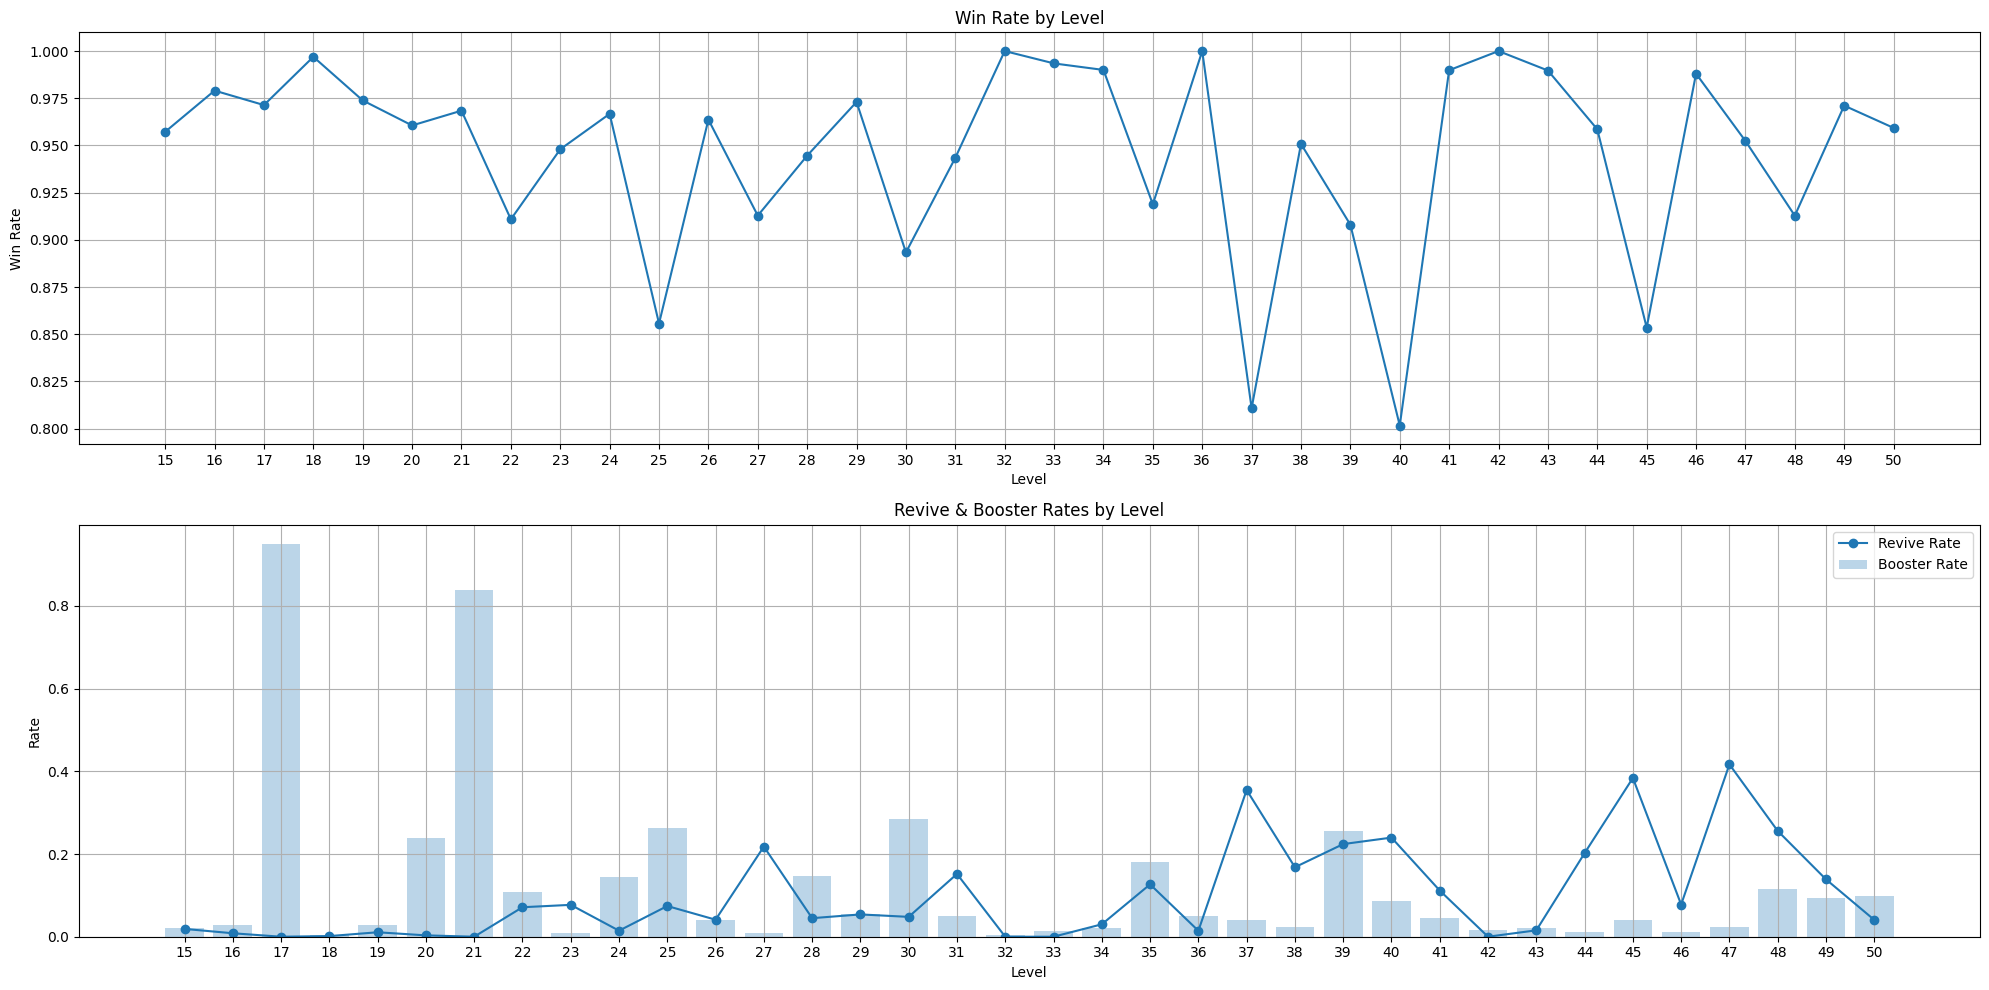

In [ ]:
import matplotlib.pyplot as plt

# Filter data for levels 15-50
df_filtered = df_general[(df_general['level'] >= 15) & (df_general['level'] <= 50)]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot win rate line chart
ax1.plot(df_filtered['level'], df_filtered['win_rate'], marker='o')
ax1.set_title('Win Rate by Level')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.grid(True)
ax1.set_xticks(df_filtered['level'])

# Plot revive and booster rates
ax2.plot(df_filtered['level'], df_filtered['revive_user_rate'], marker='o', label='Revive Rate')
ax2.bar(df_filtered['level'], df_filtered['booster_user_rate'], alpha=0.3, label='Booster Rate')
ax2.set_title('Revive & Booster Rates by Level')
ax2.set_xlabel('Level')
ax2.set_ylabel('Rate')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(df_filtered['level'])

plt.tight_layout()
plt.show()

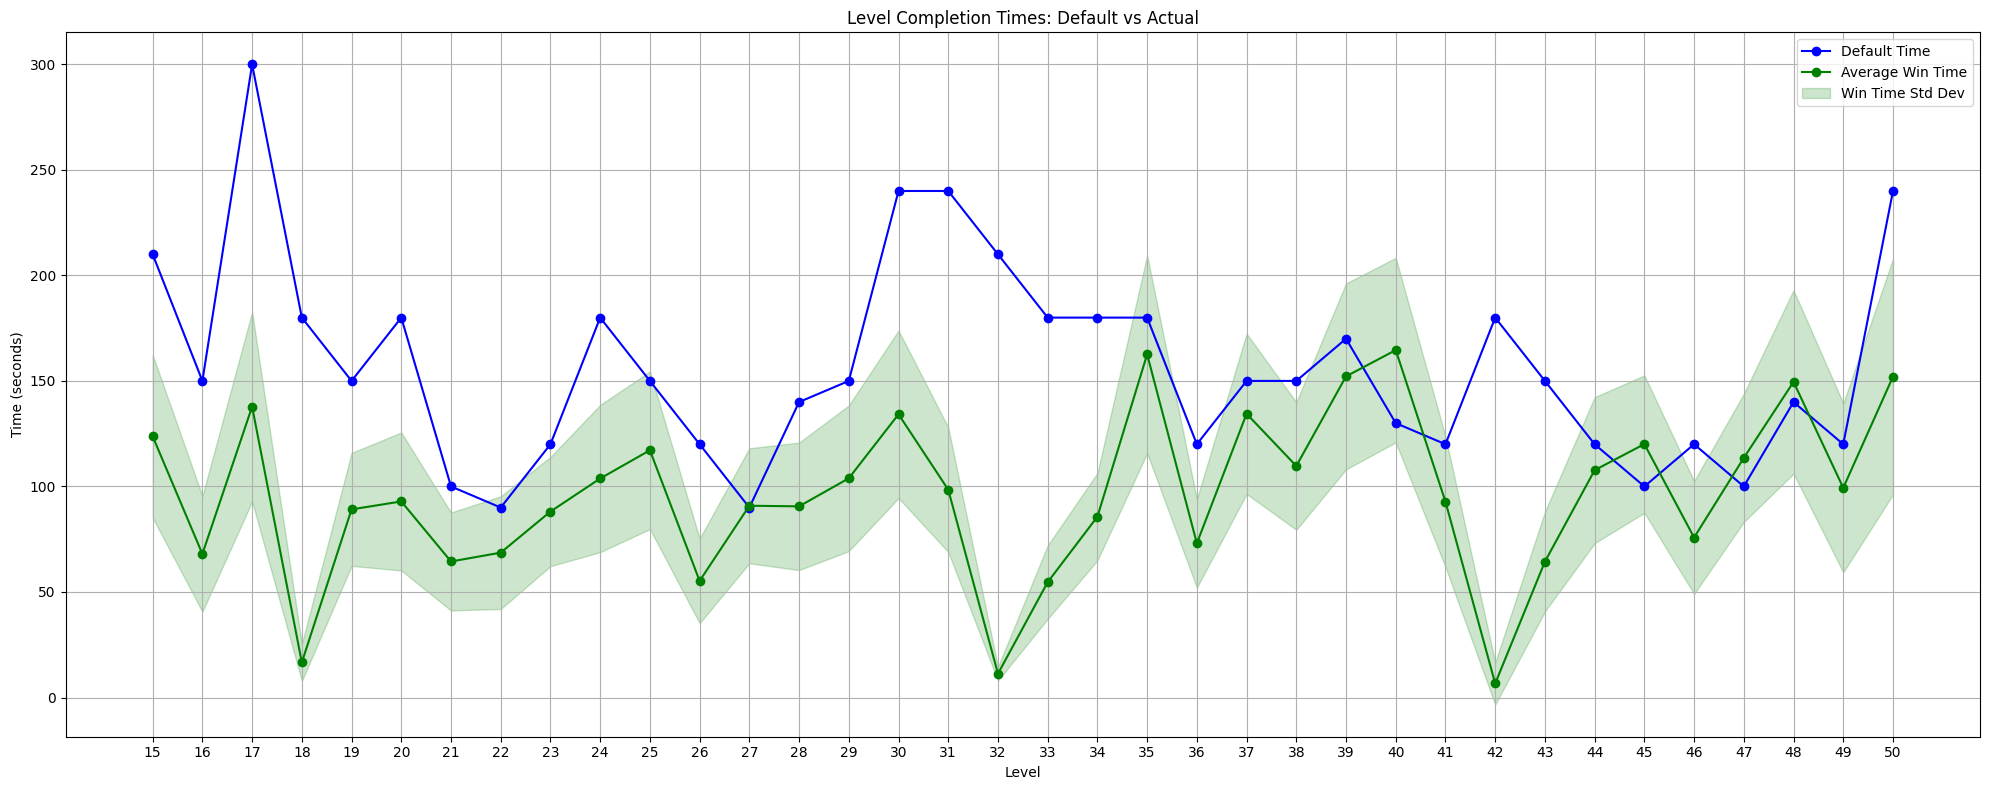

In [ ]:
# Plot time comparison
plt.figure(figsize=(20, 8))

# Plot default time line
plt.plot(df_filtered['level'], df_filtered['time_default'], marker='o', label='Default Time', color='blue')

# Plot average win time with standard deviation band
plt.plot(df_filtered['level'], df_filtered['avg_time_play_win'], marker='o', label='Average Win Time', color='green')
plt.fill_between(df_filtered['level'],
                 df_filtered['avg_time_play_win'] - df_filtered['std_time_play_win'],
                 df_filtered['avg_time_play_win'] + df_filtered['std_time_play_win'],
                 alpha=0.2, color='green', label='Win Time Std Dev')

plt.title('Level Completion Times: Default vs Actual')
plt.xlabel('Level')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.legend()
plt.xticks(df_filtered['level'])

plt.tight_layout()
plt.show()

## df_not_revive

In [ ]:
df_not_revive

,level,time_default,start_user,win_user,num_user_not_revive,avg_time_win_not_revive,std_time_win_not_revive,max_time_win_not_revive,min_time_win_not_revive
0,1,3000,1687,1669,1650,3.524501,3.542227,70,1
1,2,300,1655,1650,1648,3.224848,1.563994,20,0
2,3,300,1643,1638,1636,6.448655,4.408130,108,0
3,4,300,1628,1619,1613,19.987005,9.260814,105,0
4,5,300,1600,1584,1547,26.299486,11.966471,198,0
...,...,...,...,...,...,...,...,...,...
95,96,100,95,94,87,70.540230,19.544109,114,0
96,97,100,94,90,61,94.081967,19.710653,119,0
97,98,140,94,93,79,117.151899,22.072194,152,65
98,99,120,95,92,71,92.633803,24.851122,136,39
